### CS229 Problem Set #1

# CS 229, Public Course

## Problem Set #1: Supervised Learning

---

## 2. Locally-weighted logistic regression

In this problem you will implement a **locally-weighted version of logistic regression**, where
we **weight different training examples differently** according to the ***query point***.

The locally-weighted logistic regression problem is to **maximize**

$$l(\theta) = -\frac \lambda 2 \theta^T \theta + \sum_{i=1}^m w^{(i)} \left[ y^{(i)} log h_\theta(x^{(i)}) + (1-y^{(i)}) log (1 - h_\theta(x^{(i)})) \right]$$

The term

$$-\frac \lambda 2 \theta^T \theta$$

here is what is known as a ***regularization parameter***, which will be discussed in a future lecture, but which we include here because it is needed for Newton’s method to
perform well on this task.

For the entirety of this problem you can use the value:

* $\lambda = 0.0001$.

Using this definition, the **Gradient** of $l(\theta)$ is given by

$$\nabla_\theta l(\theta) = X^T z - \lambda \theta$$

where $z \in \mathbb R^m$ is defined by

$$z_i = w^{(i)} \left(y^{(i)} - h_\theta(x^{(i)})\right)$$

and the **Hessian** is given by

$$H = X^T D X - \lambda I$$

where $D \in \mathbb R^{mxm}$ is a diagonal matrix with

$$D_{ii} = -w^{(i)} h_\theta(x^{(i)}) \left(1 - h_\theta(x^{(i)})\right)$$

For the sake of this problem you can just use the above formulas, but you should try to derive these results for yourself as well.

---

Let's solve the equations to make it more clear:

$$l(\theta) = -\frac \lambda 2 \theta^T \theta + \sum_{i=1}^m w^{(i)} \left[ y^{(i)} log h_\theta(x^{(i)}) + (1-y^{(i)}) log (1 - h_\theta(x^{(i)})) \right]$$

$$= -\frac \lambda 2 \theta^T \theta + \sum_{i=1}^m w^{(i)} y^{(i)} log h_\theta(x^{(i)}) + w^{(i)} (1-y^{(i)}) log (1 - h_\theta(x^{(i)})) $$

$$\nabla_\theta l(\theta) = - 2 \frac \lambda 2 \theta + \sum w y \frac 1 {h_\theta (x)} h'_\theta (x) + w (1-y) \frac 1 {1 - h_\theta (x)} (- h'_\theta (x)) $$



$$= - 2 \frac \lambda 2 \theta + \sum w y \frac 1 {h_\theta (x)} h'_\theta (x) + w \frac 1 {1 - h_\theta (x)} (- h'_\theta (x)) - w y \frac 1 {1 - h_\theta (x)} (- h'_\theta (x))$$

---

Given a query point $x$, we choose compute the weights

$$w^{(i)} = exp \left( - \frac {||x-x^{(i)}||^2}{2\tau^2}\right)$$

Much like the locally weighted linear regression that was discussed in class, this weighting
scheme gives more when the “nearby” points when predicting the class of a new example.

>**a)** Implement the [***Newton-Raphson algorithm***](https://en.wikipedia.org/wiki/Newton%27s_method) for optimizing $l(\theta)$ for a **new query point** $x$, and use this to **predict the class** of $x$.
>
>The *q2/* directory contains data and code for this problem.
>
>You should implement the `y = lwlr(X train, y train, x, tau)` function in the *lwlr.m* file.
>
>This function takes as input the training set (the X_train and y_train matrices, in the form described in the >class notes), a new query point $x$ and the weight bandwitdh tau $\tau$.
>
>Given this input the function should:
>
>1. **compute weights $w^{(i)}$ *for each training example***, using the formula above
>
>2. **maximize** $l(\theta)$ using Newton’s method, and finally
>
>3. output $y = \mathbb 1\{h_\theta(x) > 0.5\}$ as the **prediction**.
>
>We provide two additional functions that might help.
>
>* The `[X train, y train] = load data;` function will load the matrices from files in the *data/* folder.
>
>* The function `plot_lwlr(X train, y train, tau, resolution)` will plot the resulting classifier (assuming you have properly implemented *lwlr.m*).
>  
>  This function **evaluates** the *locally weighted logistic regression classifier* over a **large grid of points** and plots the resulting prediction as blue (predicting y = 0) or orange (predicting y = 1).
>  
>  Depending on how fast your lwlr function is, **creating the plot might take some time**, so we recommend debugging your code with resolution = 50; and later increase it to at least 200 to get a better idea of the decision boundary.
>
>**b)** Evaluate the system with a **variety of different bandwidth parameters Tau** $\tau$.
>
>In particular, try $\tau = 0.01, 0.05, 0.1, 0.5, 1.0, 5.0$.
>
> * How does the classification boundary change when varying this parameter? 
>
> * Can you predict what the decision boundary of ordinary (unweighted) logistic regression would look like?

## Plotting the data

In [1]:
import numpy as np

def load_data():
    x = np.loadtxt('./ps1-q2/data/x.dat')
    y = np.loadtxt('./ps1-q2/data/y.dat')
    print('x data loaded with shape {}'.format(x.shape))
    print('y data loaded with shape {}'.format(y.shape))
    return x,y
x,y = load_data()

x data loaded with shape (69, 2)
y data loaded with shape (69,)


In [2]:
import matplotlib.pyplot as plt
plt.scatter(x[y==0][:,0], x[y==0][:,1], marker='o')
plt.scatter(x[y==1][:,0], x[y==1][:,1], marker='x')
plt.show()

<Figure size 640x480 with 1 Axes>

In [3]:
def weight(x, xi, tau):
    # Squared Exponential kernel
    return np.exp(-1./(2*tau**2) * np.linalg.norm((x-xi), ord=2))

def sigmoid(z):
    return 1./(1+np.exp(-z))

def h(theta, xi):
    # Hypothesis h_theta(xi)
    linear = np.dot(np.transpose(theta), xi)
    return sigmoid(linear)

def locally_weighted_logistic_regression(X_train, y_train, x, tau=0.01, lambd=1e-4):
    # Adding bias column
    X_train = np.c_[np.ones(69), X_train]
    x = np.hstack(([1], x))
    # Number of features
    n = X_train.shape[1]
    # Number of training examples
    m = len(y)
    # Weights theta in R^n
    theta = np.zeros(n)
    # lambda: Regularization parameter 
    # Regularization matrix for the Hessian
    regul = np.eye(n) * lambd
    # Diagonal matrix
    D = np.eye(m)
    # Compute usefull values to rehuse on D and z
    h_theta = [h(theta, X_train[i]) for i in range(m)]
    w_tau   = [weight(x, X_train[i], tau) for i in range(m)]
    for i in range(m):
        D[i,i] = -w_tau[i]*h_theta[i]*(1 - h_theta[i])
    # Hessian of J(0)
    H = np.dot(np.transpose(X_train), np.dot(D, X_train)) - regul
    # inverse of H
    #iH = np.linalg.inv(H)
    iH = np.linalg.pinv(H)
    z = np.array([w_tau[i]*(y_train[i]-h_theta[i]) for i in range(m)])
    # Gradient of J(0)
    gradJ = np.matmul(np.transpose(X_train), z) - lambd * theta
    # Newton's update
    theta = theta - np.dot(iH, gradJ)
    return h(theta, x)

In [4]:
def lwlr(X_train, y_train, x, tau=0.2):
    return locally_weighted_logistic_regression(X_train, y_train, x, tau)

In [5]:
# For time debugging
#%lprun?
#%load_ext line_profiler
#%lprun -f locally_weighted_logistic_regression locally_weighted_logistic_regression(x, y, point, 0.1)

### Evaluate new point

In [6]:
# New point to evaluate
point = np.array([-0.6, 0.7])

#### Lets plot it

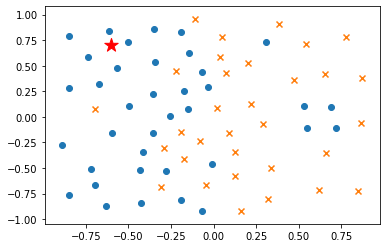

In [7]:
import matplotlib.pyplot as plt
plt.scatter(x[y==0][:,0], x[y==0][:,1], marker='o')
plt.scatter(x[y==1][:,0], x[y==1][:,1], marker='x')
plt.scatter(point[0], point[1], marker='*', s=200, c='r')
plt.show()

#### LWLR Prediction:

In [8]:
locally_weighted_logistic_regression(x, y, point, tau=0.2)

0.12068918648271217

Very close to class 0

#### Predictions and confidence

In [9]:
# New points to evaluate
point1 = np.array([-0.6, 0.7])
point2 = np.array([0.4, -0.7])
point3 = np.array([0.4, 0.0])

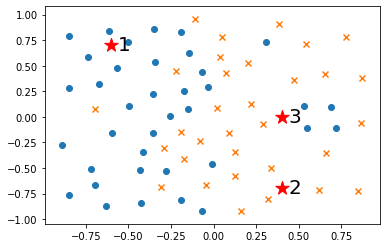

In [10]:
import matplotlib.pyplot as plt
plt.scatter(x[y==0][:,0], x[y==0][:,1], marker='o')
plt.scatter(x[y==1][:,0], x[y==1][:,1], marker='x')

plt.scatter(point1[0], point1[1], marker='*', s=200, c='r')
plt.text(point1[0]+0.04, point1[1]-0.05, '1', size=20)

plt.scatter(point2[0], point2[1], marker='*', s=200, c='r')
plt.text(point2[0]+0.04, point2[1]-0.05, '2', size=20)

plt.scatter(point3[0], point3[1], marker='*', s=200, c='r')
plt.text(point3[0]+0.04, point3[1]-0.05, '3', size=20)

plt.show()

In [11]:
print('Prediction for point1: %.3f >> class: %d' % (lwlr(x, y, point1), round(lwlr(x, y, point1))))
print('Prediction for point2: %.3f >> class: %d' % (lwlr(x, y, point2), round(lwlr(x, y, point2))))
print('Prediction for point3: %.3f >> class: %d' % (lwlr(x, y, point3), round(lwlr(x, y, point3))))

Prediction for point1: 0.121 >> class: 0
Prediction for point2: 0.878 >> class: 1
Prediction for point3: 0.548 >> class: 1


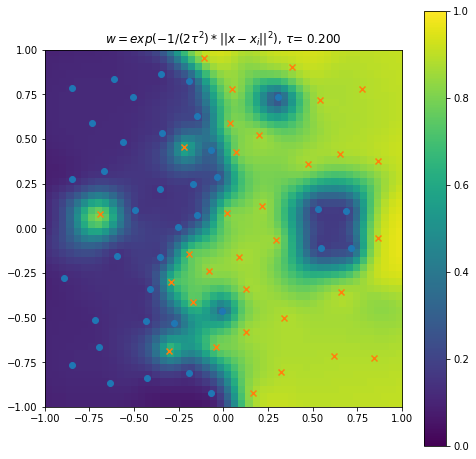

In [12]:
figure = plt.gcf() # get current figure
figure.set_size_inches(8, 8)
# when saving, specify the DPI

def lwlr_grid(X, y, i, j, res, tau, lambd):
    return locally_weighted_logistic_regression(X, y, np.asarray([2*i/(res-1)-1, 2*j/(res-1)-1]), tau, lambd)

def plot_lwlr(X, y, tau, lambd=1e-4, res=50, save=False, idx=0):
    # Evaluates a grid of (res x res) points (x0,x1)
    x = np.zeros(2)
    pred = np.ndarray((res,res))
    x0s = 2*np.arange(0, res)/(res-1) - 1
    x1s = 2*np.arange(0, res)/(res-1) - 1
    for i in range(res):
        for j in range(res):
            #x[0] = 2*i/(res-1) - 1
            #x[1] = 2*j/(res-1) - 1
            pred[j,i] = locally_weighted_logistic_regression(X, y, [x0s[i], x1s[j]], tau, lambd)
    plt.imshow(pred, extent=[-1, 1, -1, 1], aspect='equal', vmin=0.0, vmax=1.0, origin='lower')
    plt.scatter(X[y==0][:,0], X[y==0][:,1], marker='o')
    plt.scatter(X[y==1][:,0], X[y==1][:,1], marker='x')
    plt.title(r'$w=exp(-1/(2\tau^2) * || x-x_i||^2)$, $\tau$'+'= {0:.3f}'.format(tau))
    plt.colorbar()
    if save:
        plt.savefig('./animation/{}.png'.format(idx), dpi=100)
        print('Saved ./animation/{}.png'.format(idx))
        plt.close()
    else:
        plt.show()
    
plot_lwlr(x, y, tau=0.2, lambd=1e-4, res=50)

**(b)**

## Incidence of Tau $\tau$

The next for loop tries several Tau values from 0.01 to 1.2, and saves the corresponding colormap with the predicted grid values as before.

Online animations should be loaded just after that cell.

In [279]:
for idx, tau in enumerate(np.arange(0.01, 0.3, 0.001)):
    plot_lwlr(x, y, tau, lambd=1e-4, res=200, save=True, idx=idx)

Saved ./animation/0.png
Saved ./animation/1.png
Saved ./animation/2.png
Saved ./animation/3.png
Saved ./animation/4.png
Saved ./animation/5.png
Saved ./animation/6.png
Saved ./animation/7.png
Saved ./animation/8.png
Saved ./animation/9.png
Saved ./animation/10.png
Saved ./animation/11.png
Saved ./animation/12.png
Saved ./animation/13.png
Saved ./animation/14.png
Saved ./animation/15.png
Saved ./animation/16.png
Saved ./animation/17.png
Saved ./animation/18.png
Saved ./animation/19.png
Saved ./animation/20.png
Saved ./animation/21.png
Saved ./animation/22.png
Saved ./animation/23.png
Saved ./animation/24.png
Saved ./animation/25.png
Saved ./animation/26.png
Saved ./animation/27.png
Saved ./animation/28.png
Saved ./animation/29.png
Saved ./animation/30.png
Saved ./animation/31.png
Saved ./animation/32.png
Saved ./animation/33.png
Saved ./animation/34.png
Saved ./animation/35.png
Saved ./animation/36.png
Saved ./animation/37.png
Saved ./animation/38.png
Saved ./animation/39.png
Saved ./an

![](https://media.giphy.com/media/Qx5QKQCBj5WRsltbAP/giphy.gif)

### Questions:
> How does the classification boundary change when varying this parameter?

It makes the borders more or less difuse, changing the weights for each distances.

* Bigger Tau > Similar weights for each other point
* Smaller Tau > More importance to closed by points.

> Can you predict what the decision boundary of ordinary (unweighted) logistic regression would look like?

It will look pretty similar to the results of very large tau, which makes all weights $\approx 1$

$$w^{(i)} = exp \left( - \frac {||x-x^{(i)}||^2}{2\tau^2}\right)$$

if $\tau \rightarrow \infty$

$$w^{(i)} \approx exp \left( 0 \right)$$

$$w^{(i)} \approx 1$$

So ***all points will have the same weight, as in unweighted logistic regression***.

## Multivariate least squares